In [1]:
import csv
import sys
import numpy as np
import pandas as pd

sys.path.append('../..')

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from src.analyzer.corpus_statistics import calculate_corpus_statistics
from src.analyzer.calculate_dimensions import calculate_dimensions

### Read in the train and test datasets

In [2]:
train = pd.read_csv('../../data/train_60k_sample.tsv', sep='\t', quoting=csv.QUOTE_NONE, encoding='utf-8', escapechar='\\', error_bad_lines=False)
test =  pd.read_csv('../../data/test_60k_sample.tsv', sep='\t', quoting=csv.QUOTE_NONE, encoding='utf-8', escapechar='\\', error_bad_lines=False)
train.head()

/var/folders/6y/4xz13f9n0n18x94nx555hjpw0000gr/T/ipykernel_9073/2487301018.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train = pd.read_csv('../../data/train_60k_sample.tsv', sep='\t', quoting=csv.QUOTE_NONE, encoding='utf-8', escapechar='\\', error_bad_lines=False)
/var/folders/6y/4xz13f9n0n18x94nx555hjpw0000gr/T/ipykernel_9073/2487301018.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test =  pd.read_csv('../../data/test_60k_sample.tsv', sep='\t', quoting=csv.QUOTE_NONE, encoding='utf-8', escapechar='\\', error_bad_lines=False)


,documentID,authorID,text,source,dataset
0,2504062,"Ficicioglu, Can",\nSubstrate reduction therapy is an alternativ...,Pubmed,Pubmed
1,25vk40,4e09be32-a6a6-d98a-68b2-1bfd5ea8f980,"Alright, so… me and four friends are travellin...",subreddit-travel,Reddit
2,24e53035-94d6-932b-c49c-21f91a717968,54fa7e77-8bd1-c624-aa2a-c67785f6c798,"He awoke about the middle of the night, and up...",Book3Corpus,BookCorpus
3,2961885,"Cheng, Xiang-Wei","\nFor general background, see: Hadjoudis",Pubmed,Pubmed
4,3b43ee8e-208e-4f0b-92d1-b41598d3bacd,A3CDEV87QLXI53,I got these discs and they were all damaged an...,amazon,Amazon


### Compute the dimensions for both train and test authors

In [3]:
def compute_dimensions(df):
    dim_rows = []

    for row in tqdm(df.itertuples(), total=len(df)):
        corpus_stats = calculate_corpus_statistics(row.text, 
                                          token_batch_size=2000, 
                                          token_normalization=100, 
                                          show_progress=False, use_gpu=False)
        dimensions = calculate_dimensions(corpus_stats)
        dimensions['author'] = row.authorID
        dimensions['dataset'] = row.dataset

        dim_rows.append(dimensions)
    return pd.DataFrame(dim_rows)

In [4]:
test_dims = compute_dimensions(test)

  0%|                                                                                                                                                                                                                | 28/60497 [00:09<5:48:25,  2.89it/s]


KeyboardInterrupt: 

In [ ]:
dim_rows = []

for row in tqdm(samples_df.itertuples(), total=len(samples_df)):
    corpus_stats = calculate_corpus_statistics(row.text, 
                                      token_batch_size=2000, 
                                      token_normalization=100, 
                                      show_progress=False, use_gpu=False)
    dimensions = calculate_dimensions(corpus_stats)
    dimensions['author'] = row.authorID
    dimensions['dataset'] = row.dataset
    
    dim_rows.append(dimensions)

### Evaluate R@8 based on Euclidean Distance

In [7]:
dim_df = pd.read_csv('../analyzer/author_dimensions.csv')
dim_df.head()

,1,2,3,4,5,6,author,dataset
0,10.543596,-7.248454,2.280966,-8.765124,-2.670088,-3.314122,AQUU8S55JGY2H,Amazon
1,10.059491,-5.222700,1.584616,-8.513468,-2.373329,-3.363592,52e43081-58d7-8abe-f41c-a2c2e4db7097,News
2,10.185978,-7.119931,2.117917,-9.153395,-1.676906,-3.495074,766dfe84-dae8-e013-b57d-2b4cc532076d,Reddit
3,9.926020,-6.814032,2.528302,-9.115703,-1.872013,-3.415709,6309556.0,Wiki
4,9.184673,-7.017368,1.604767,-9.206371,-1.386046,-3.495074,5641591.0,Wiki


**Split into train/test set**

In [34]:
train, test = train_test_split(dim_df, test_size=0.1)
print(len(train), len(test))

5400 600


In [35]:
y_train, y_test = train['dataset'], test['dataset']

X_train = train.drop(['author', 'dataset'], axis=1)
X_test = test.drop(['author', 'dataset'], axis=1)

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

5400 5400
600 600


### Train a KNN Model

In [36]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [37]:
y_preds = neigh.predict(X_test)

In [38]:
accuracy_score(y_test, y_preds)

0.5416666666666666

Text(0, 0.5, 'Model')

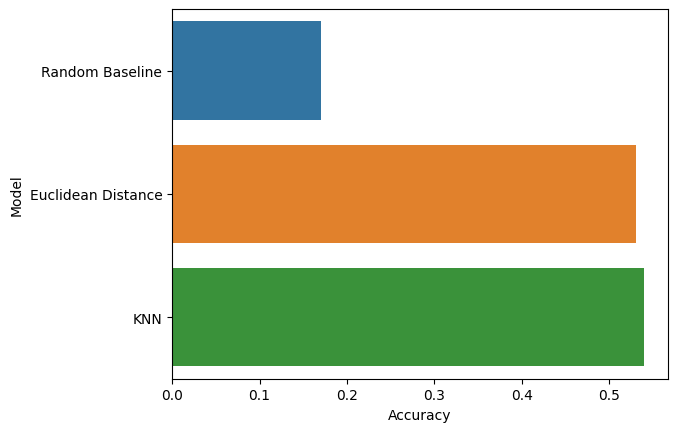

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=[0.17, 0.53, 0.54], y=['Random Baseline', 'Euclidean Distance', 'KNN'], orient='h')
plt.xlabel('Accuracy')
plt.ylabel('Model')
